In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

print(keras.__version__)
print(tf.__version__)

#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=5 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("../data/data_batches/batch_1/patch_img/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        # print(img_path)
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

#Capture mask/label info as a list
train_masks = [] 

for directory_path in glob.glob("../data/data_batches/batch_1/patch_mask/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        # print(mask_path)
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(train_masks.shape)

#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
# X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
# #Further split training data t a smaller subset for quick testing of models
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.3, random_state = 0)


#Full Data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

# Add print statements to check tensor shapes
print("Input shapes:")
print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)


###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

Segmentation Models: using `keras` framework.
2.13.1
2.14.0
(4667, 256, 256, 3)
(4667, 256, 256)


C:\Users\sagni\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class values in the dataset are ...  [0 1 2 3 4]
Input shapes:
X_train shape: (3733, 256, 256, 3)
y_train_cat shape: (3733, 256, 256, 5)
X_test shape: (934, 256, 256, 3)
y_test_cat shape: (934, 256, 256, 5)


In [3]:
from keras.models import load_model
### FOR NOW LET US FOCUS ON A SINGLE MODEL
BACKBONE = "resnet34"
#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model(f'../FurtherTraining/CheckPoints/{BACKBONE}/weights-improvement_resnet34.hdf5', compile=False)

# plot graph
#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

30/30 [==============================] - 72s 2s/step
Mean IoU = 0.6701618


In [4]:
import numpy as np

# Assuming n_classes = 5
n_classes = 5

# Initialize your confusion matrix 'values'
# Replace this with your actual confusion matrix
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

# Calculate IoU for each class
class_IoU = []
for i in range(n_classes):
    numerator = values[i, i]
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i]

    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-10
    class_IoU.append(numerator / (denominator + epsilon))

# Print IoU for each class
for i in range(n_classes):
    print(f"IoU for class {i+1} is: {class_IoU[i]}")


IoU for class 1 is: 0.6964700131114179
IoU for class 2 is: 0.6435647132721675
IoU for class 3 is: 0.7482764040449669
IoU for class 4 is: 0.7814606232156912
IoU for class 5 is: 0.48103734112260205


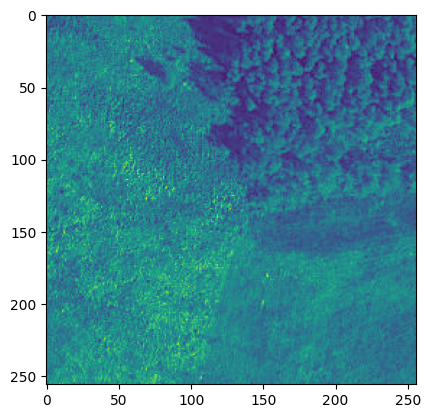

In [5]:
plt.imshow(train_images[0, :,:,0])

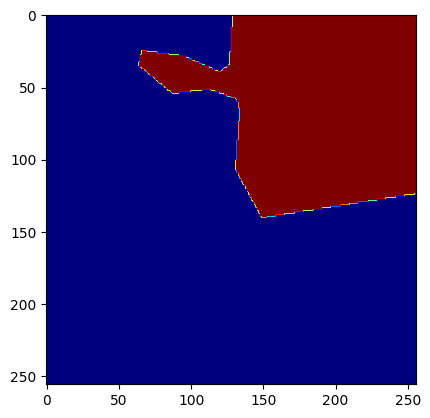

In [6]:
plt.imshow(train_masks[0], cmap='jet')

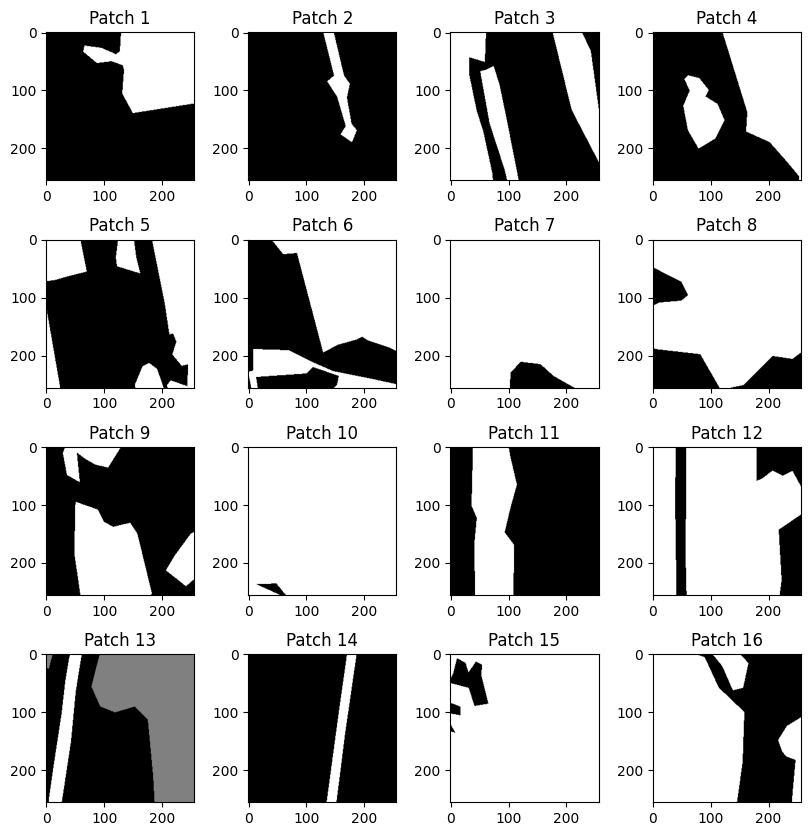

In [7]:
import matplotlib.pyplot as plt

# Create a figure with a larger size
fig = plt.figure(figsize=(10, 10))

# Assuming train_masks contains at least 16 mask images
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots
    ax.imshow(train_masks[i], cmap='gray') #16 patches make a single image
    ax.set_title(f"Patch {i + 1}")  # Add a title for each subplot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()  # Display all 16 images

(1, 256, 256, 3)
1/1 [==============================] - 0s 95ms/step
(256, 256)


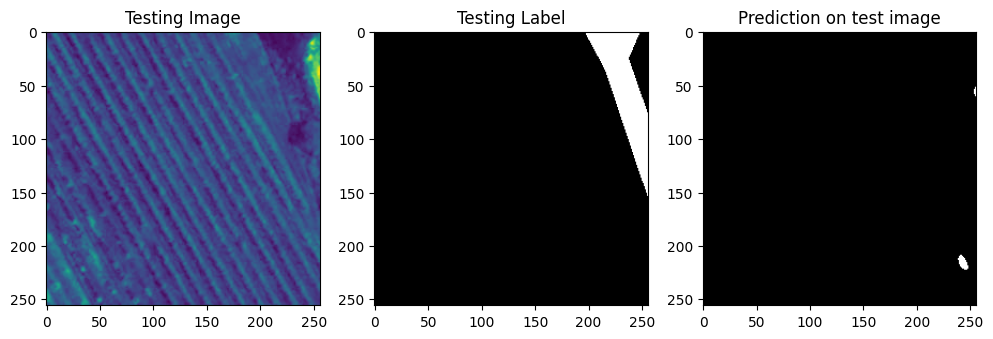

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


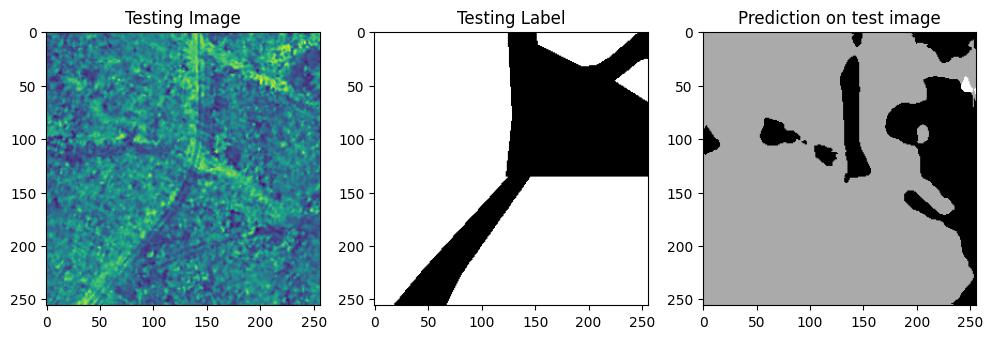

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


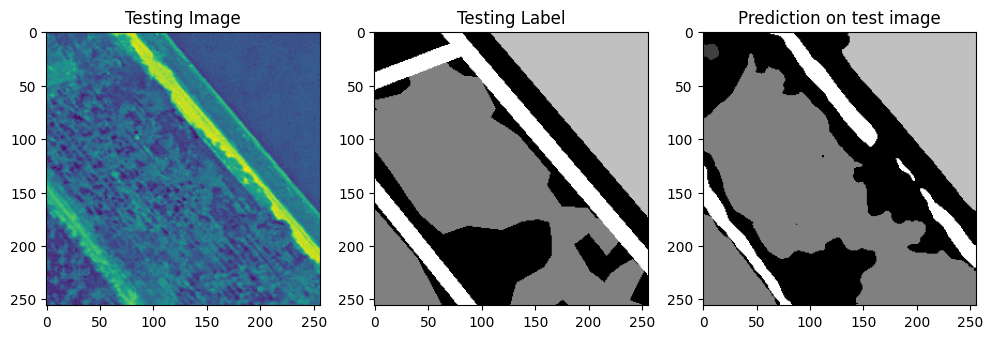

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


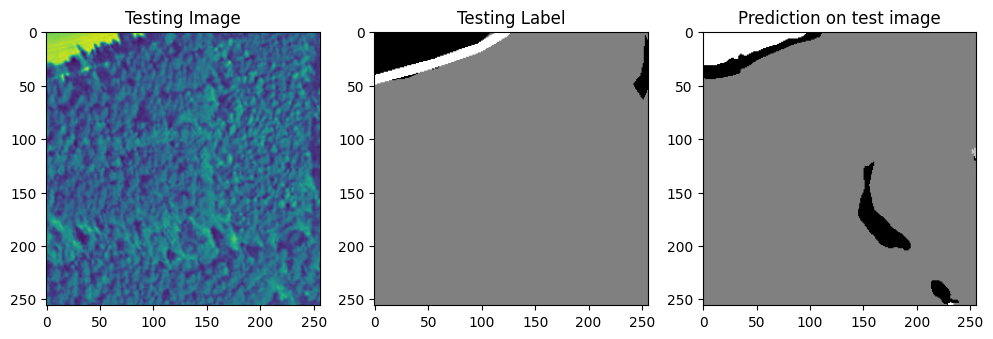

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


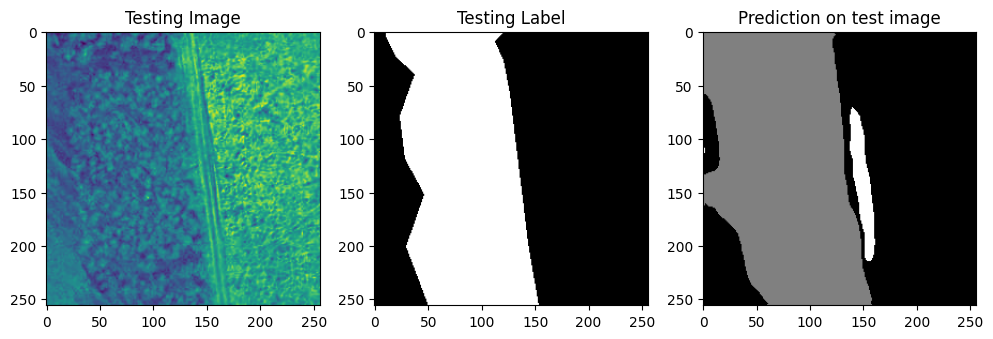

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


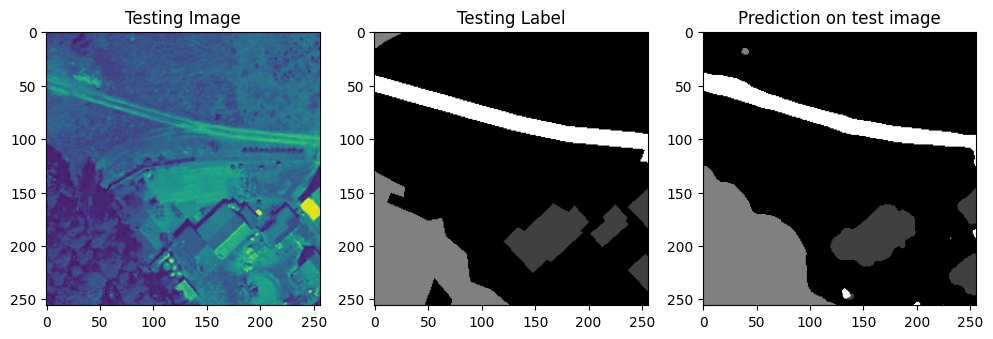

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


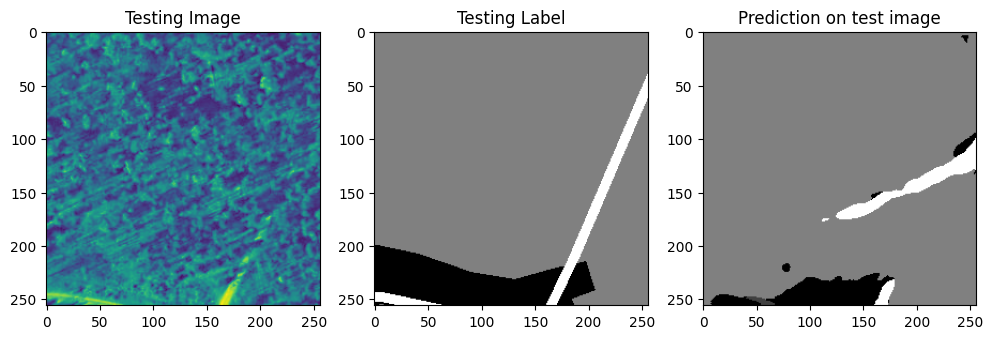

(1, 256, 256, 3)
1/1 [==============================] - 0s 95ms/step
(256, 256)


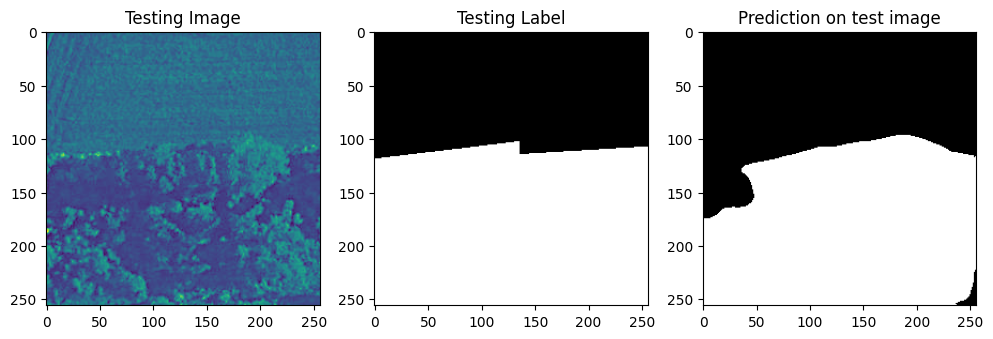

(1, 256, 256, 3)
1/1 [==============================] - 0s 110ms/step
(256, 256)


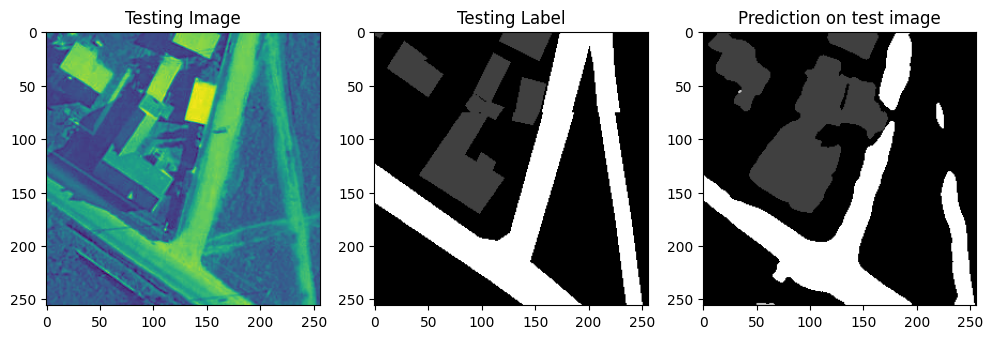

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


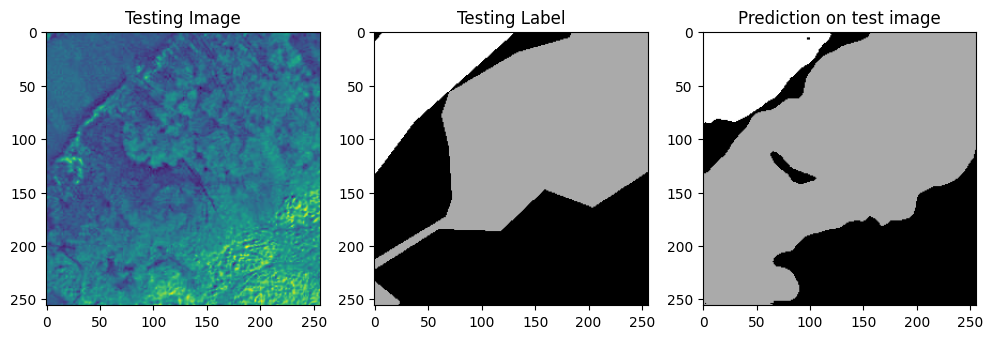

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


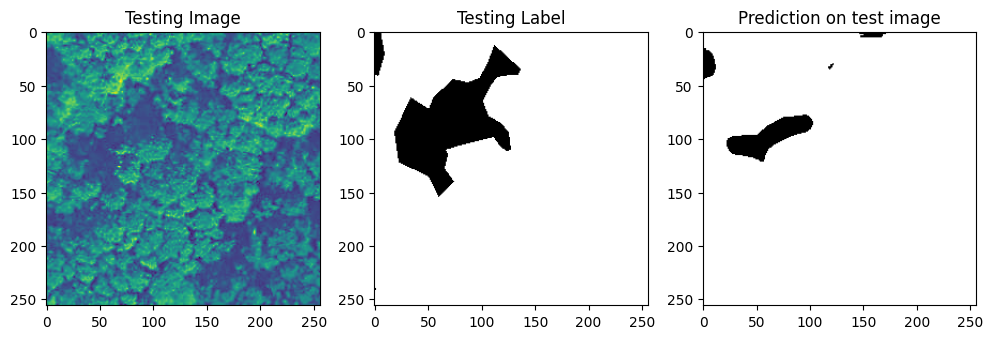

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


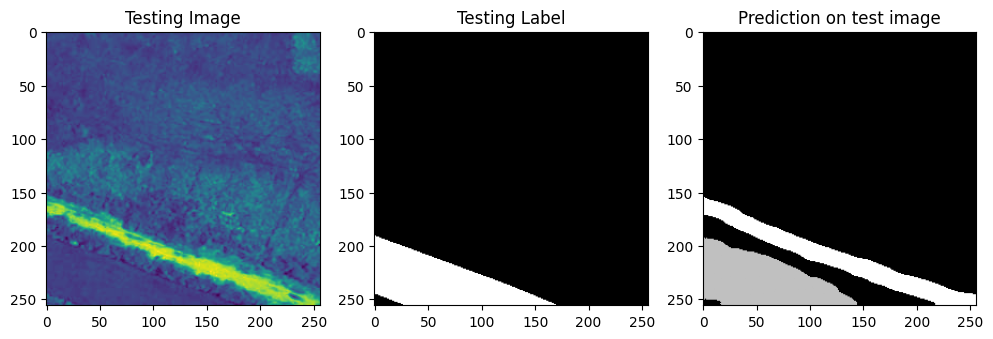

(1, 256, 256, 3)
1/1 [==============================] - 0s 98ms/step
(256, 256)


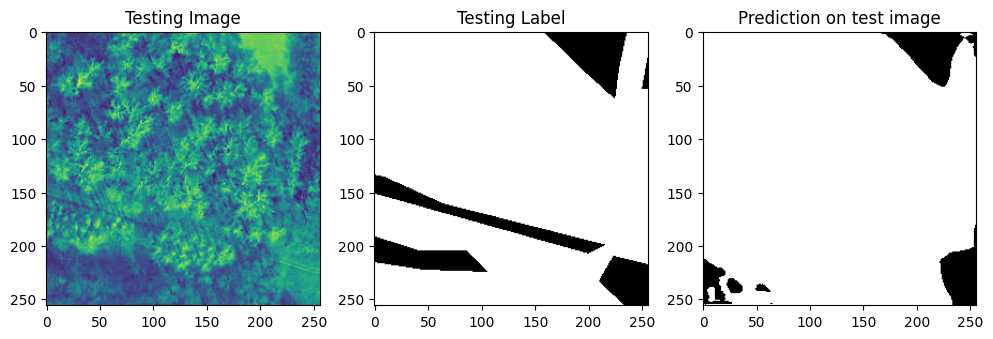

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


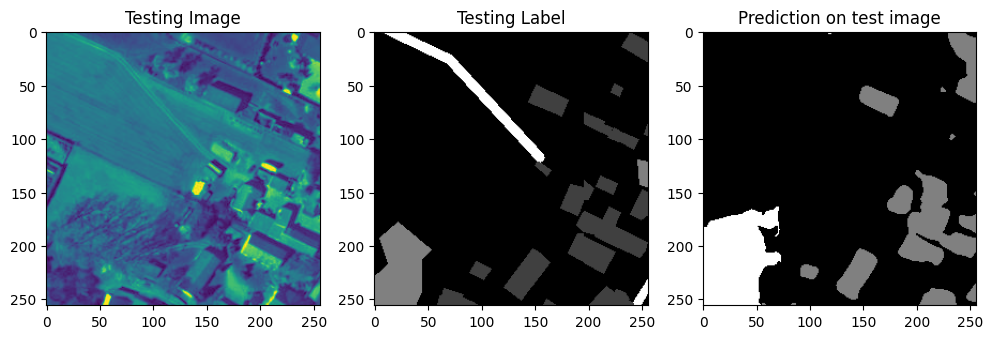

(1, 256, 256, 3)
1/1 [==============================] - 0s 95ms/step
(256, 256)


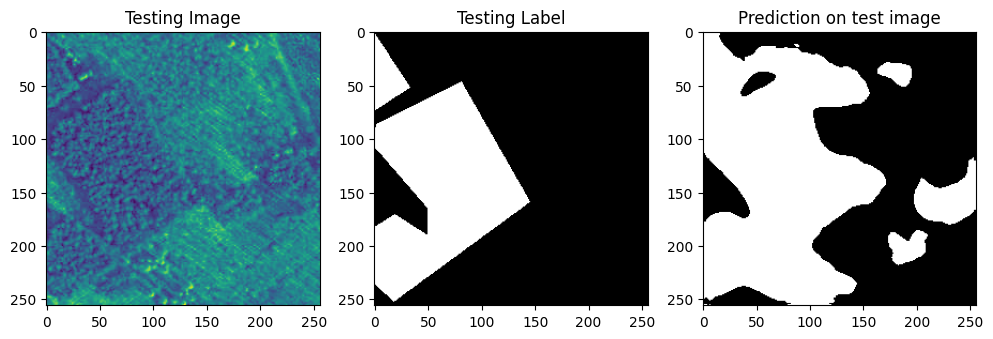

(1, 256, 256, 3)
1/1 [==============================] - 0s 96ms/step
(256, 256)


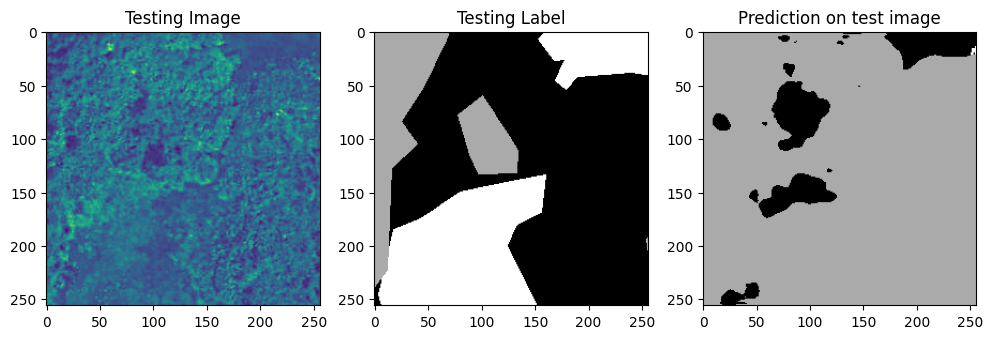

(1, 256, 256, 3)
1/1 [==============================] - 0s 100ms/step
(256, 256)


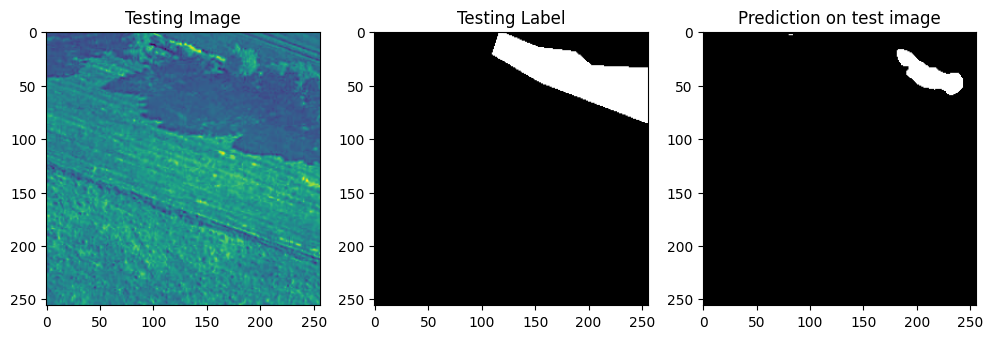

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


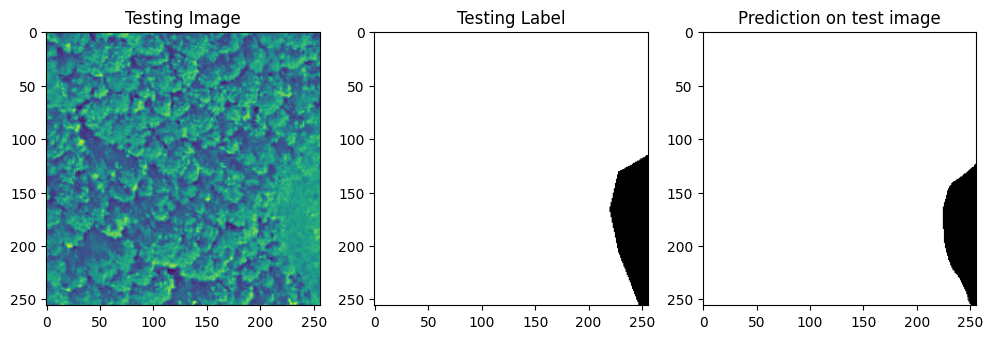

(1, 256, 256, 3)
1/1 [==============================] - 0s 94ms/step
(256, 256)


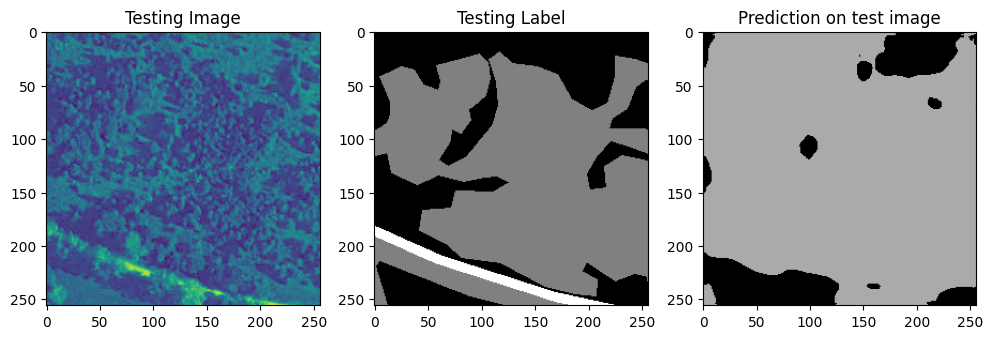

(1, 256, 256, 3)
1/1 [==============================] - 0s 95ms/step
(256, 256)


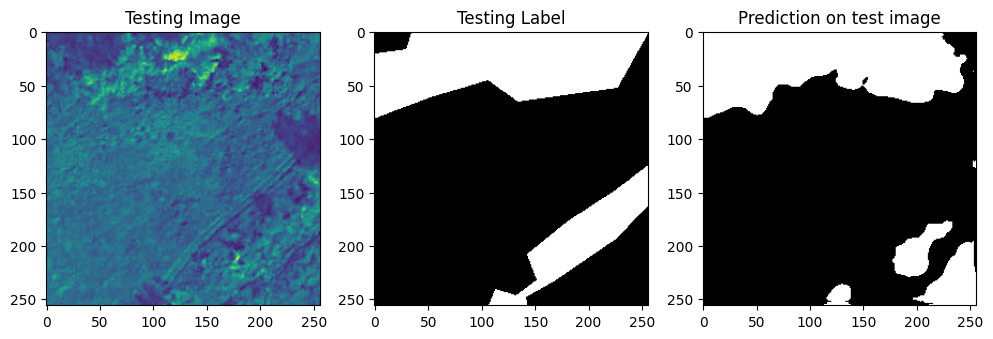

In [8]:
# Test some random images
for j in range(20):
    import random
    test_img_number = random.randint(0, len(X_test1)-1)
    test_img = X_test1[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    
    test_img_input1 = preprocess_input1(test_img_input)
    print(test_img_input1.shape)
    test_pred1 = model1.predict(test_img_input1)
    test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
    print(test_prediction1.shape)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0])
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction1, cmap='gray')
    plt.show()

In [9]:
"""
https://github.com/Vooban/Smoothly-Blend-Image-Patches
"""

import cv2
import numpy as np

from matplotlib import pyplot as plt
import segmentation_models as sm

from smooth_tiled_predictions import predict_img_with_smooth_windowing

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 37s 2s/step


 12%|██████████▌                                                                         | 1/8 [00:41<04:47, 41.03s/it]

18/18 [==============================] - 45s 3s/step


 25%|█████████████████████                                                               | 2/8 [01:29<04:33, 45.54s/it]

18/18 [==============================] - 44s 2s/step


 38%|███████████████████████████████▌                                                    | 3/8 [02:17<03:52, 46.52s/it]

18/18 [==============================] - 45s 3s/step


 50%|██████████████████████████████████████████                                          | 4/8 [03:06<03:10, 47.70s/it]

18/18 [==============================] - 49s 3s/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [03:58<02:27, 49.08s/it]

18/18 [==============================] - 49s 3s/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [04:51<01:40, 50.32s/it]

18/18 [==============================] - 47s 3s/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [05:40<00:50, 50.10s/it]

18/18 [==============================] - 47s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:30<00:00, 48.84s/it]


(2096, 4096)
(2096, 4096)
segmentation_results/resnet34/segmented/image_0_segmented_resnet34.jpg
segmentation_results/resnet34/mask/image_0_mask_resnet34.jpg


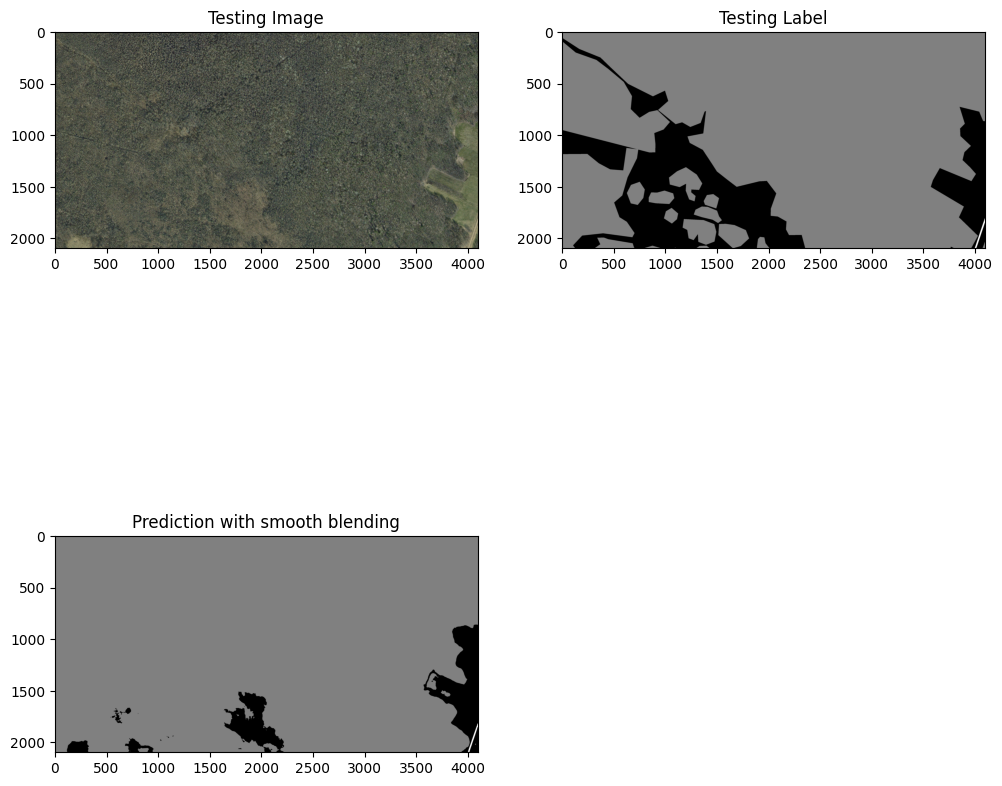

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 53s 3s/step


 12%|██████████▌                                                                         | 1/8 [00:56<06:32, 56.00s/it]

18/18 [==============================] - 51s 3s/step


 25%|█████████████████████                                                               | 2/8 [01:50<05:29, 54.92s/it]

18/18 [==============================] - 53s 3s/step


 38%|███████████████████████████████▌                                                    | 3/8 [02:45<04:36, 55.32s/it]

18/18 [==============================] - 48s 3s/step


 50%|██████████████████████████████████████████                                          | 4/8 [03:37<03:35, 53.91s/it]

18/18 [==============================] - 47s 3s/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:27<02:37, 52.40s/it]

18/18 [==============================] - 47s 3s/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:17<01:43, 51.52s/it]

18/18 [==============================] - 46s 3s/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [06:06<00:50, 50.74s/it]

18/18 [==============================] - 47s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:56<00:00, 52.00s/it]


(2096, 4096)
(2096, 4096)
segmentation_results/resnet34/segmented/image_16_segmented_resnet34.jpg
segmentation_results/resnet34/mask/image_16_mask_resnet34.jpg


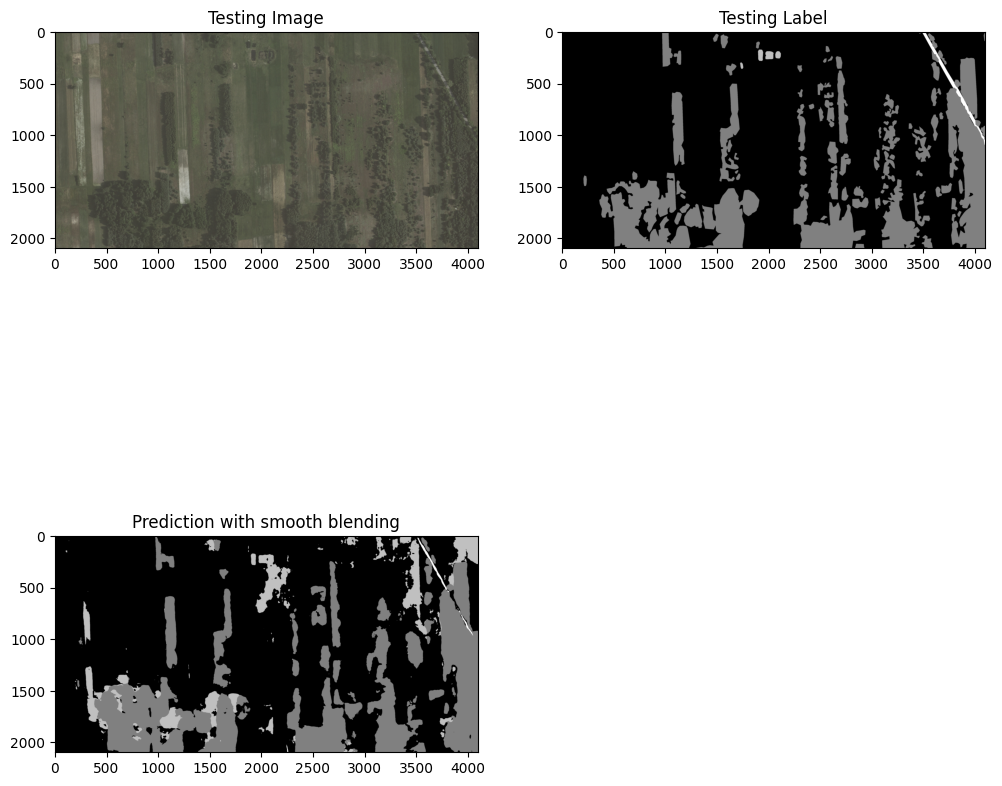

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 47s 3s/step


 12%|██████████▌                                                                         | 1/8 [00:49<05:47, 49.69s/it]

18/18 [==============================] - 48s 3s/step


 25%|█████████████████████                                                               | 2/8 [01:41<05:04, 50.69s/it]

18/18 [==============================] - 47s 3s/step


 38%|███████████████████████████████▌                                                    | 3/8 [02:30<04:10, 50.15s/it]

18/18 [==============================] - 47s 3s/step


 50%|██████████████████████████████████████████                                          | 4/8 [03:21<03:21, 50.32s/it]

18/18 [==============================] - 46s 3s/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:10<02:29, 49.97s/it]

18/18 [==============================] - 49s 3s/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:02<01:41, 50.65s/it]

18/18 [==============================] - 47s 3s/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [05:52<00:50, 50.36s/it]

18/18 [==============================] - 46s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:41<00:00, 50.20s/it]


(2096, 4096)
(2096, 4096)
segmentation_results/resnet34/segmented/image_23_segmented_resnet34.jpg
segmentation_results/resnet34/mask/image_23_mask_resnet34.jpg


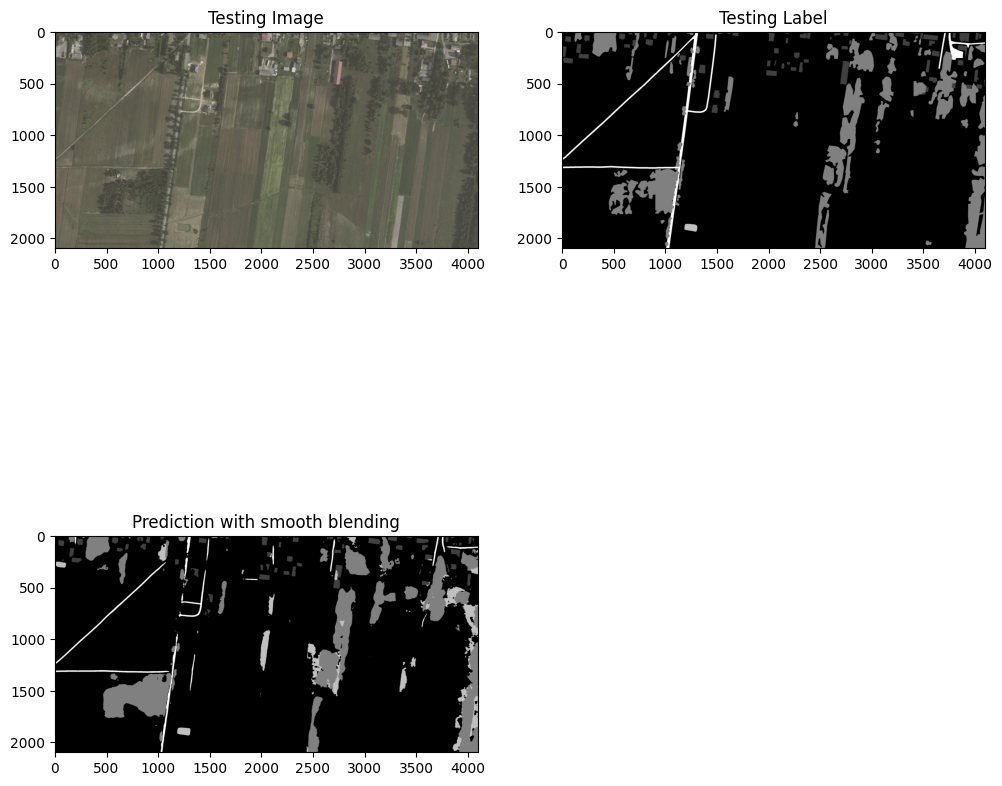

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 49s 3s/step


 12%|██████████▌                                                                         | 1/8 [00:51<06:03, 51.97s/it]

18/18 [==============================] - 47s 3s/step


 25%|█████████████████████                                                               | 2/8 [01:41<05:03, 50.53s/it]

18/18 [==============================] - 46s 3s/step


 38%|███████████████████████████████▌                                                    | 3/8 [02:30<04:10, 50.04s/it]

18/18 [==============================] - 47s 3s/step


 50%|██████████████████████████████████████████                                          | 4/8 [03:21<03:20, 50.12s/it]

18/18 [==============================] - 47s 3s/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:10<02:29, 49.89s/it]

18/18 [==============================] - 47s 3s/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:00<01:39, 49.89s/it]

18/18 [==============================] - 47s 3s/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [05:50<00:49, 49.90s/it]

18/18 [==============================] - 54s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:47<00:00, 50.98s/it]


(2096, 4096)
(2096, 4096)
segmentation_results/resnet34/segmented/image_30_segmented_resnet34.jpg
segmentation_results/resnet34/mask/image_30_mask_resnet34.jpg


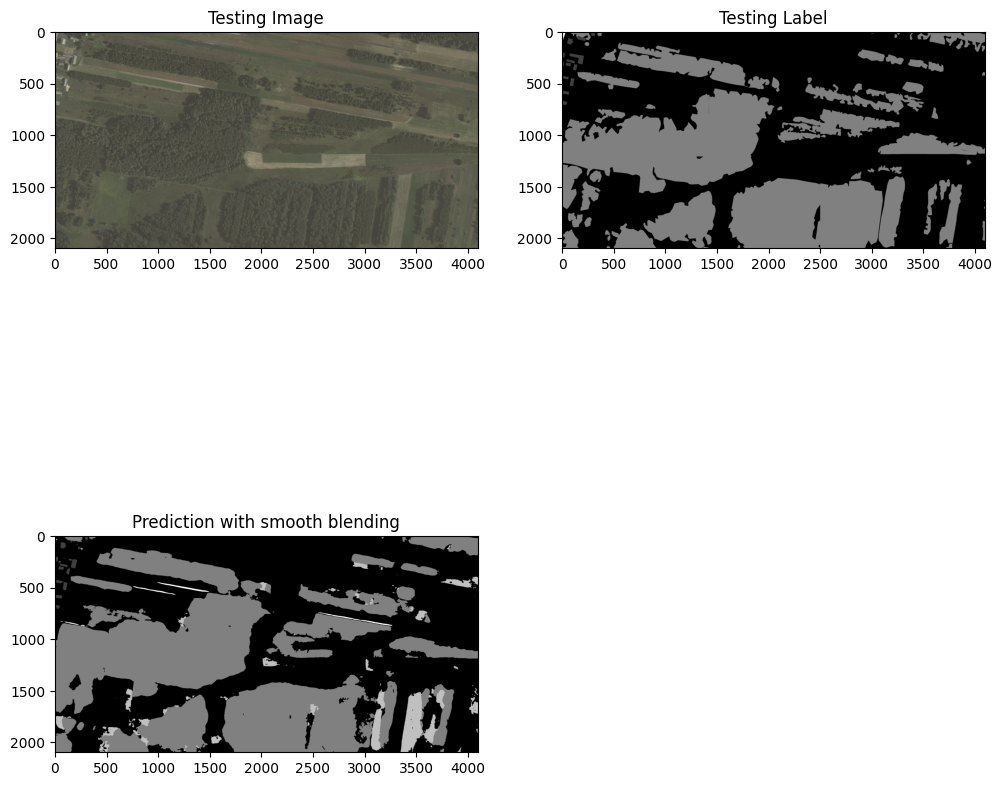

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 50s 3s/step


 12%|██████████▌                                                                         | 1/8 [00:53<06:14, 53.56s/it]

18/18 [==============================] - 50s 3s/step


 25%|█████████████████████                                                               | 2/8 [01:46<05:18, 53.15s/it]

18/18 [==============================] - 49s 3s/step


 38%|███████████████████████████████▌                                                    | 3/8 [02:38<04:23, 52.63s/it]

18/18 [==============================] - 48s 3s/step


 50%|██████████████████████████████████████████                                          | 4/8 [03:29<03:28, 52.20s/it]

18/18 [==============================] - 49s 3s/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:21<02:36, 52.07s/it]

18/18 [==============================] - 50s 3s/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:14<01:44, 52.25s/it]

18/18 [==============================] - 48s 3s/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [06:05<00:51, 51.97s/it]

18/18 [==============================] - 48s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:57<00:00, 52.15s/it]


(2096, 4096)
(2096, 4096)
segmentation_results/resnet34/segmented/image_38_segmented_resnet34.jpg
segmentation_results/resnet34/mask/image_38_mask_resnet34.jpg


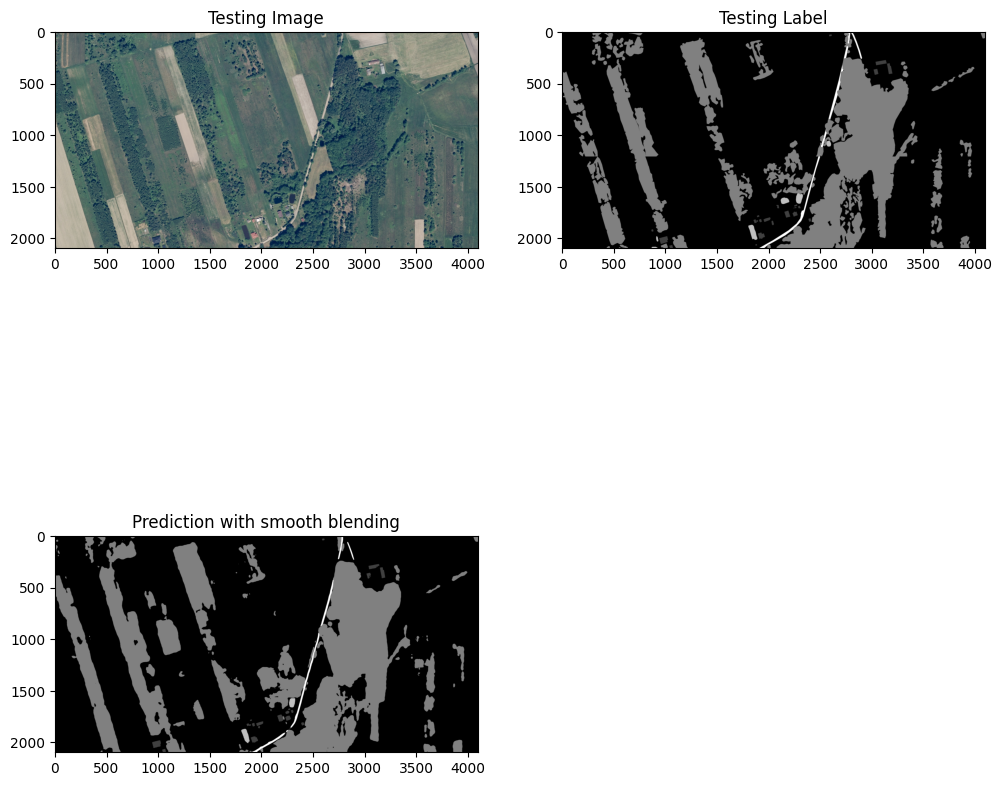

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

18/18 [==============================] - 51s 3s/step


 12%|██████████▌                                                                         | 1/8 [00:54<06:21, 54.45s/it]

18/18 [==============================] - 49s 3s/step


 25%|█████████████████████                                                               | 2/8 [01:46<05:16, 52.81s/it]

18/18 [==============================] - 53s 3s/step


 38%|███████████████████████████████▌                                                    | 3/8 [02:42<04:31, 54.40s/it]

18/18 [==============================] - 47s 3s/step


 50%|██████████████████████████████████████████                                          | 4/8 [03:32<03:30, 52.75s/it]

18/18 [==============================] - 46s 3s/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:21<02:34, 51.51s/it]

18/18 [==============================] - 46s 3s/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:11<01:41, 50.86s/it]

18/18 [==============================] - 48s 3s/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [06:02<00:50, 50.77s/it]

18/18 [==============================] - 47s 3s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:51<00:00, 51.49s/it]


(2096, 4096)
(2096, 4096)
segmentation_results/resnet34/segmented/image_45_segmented_resnet34.jpg
segmentation_results/resnet34/mask/image_45_mask_resnet34.jpg


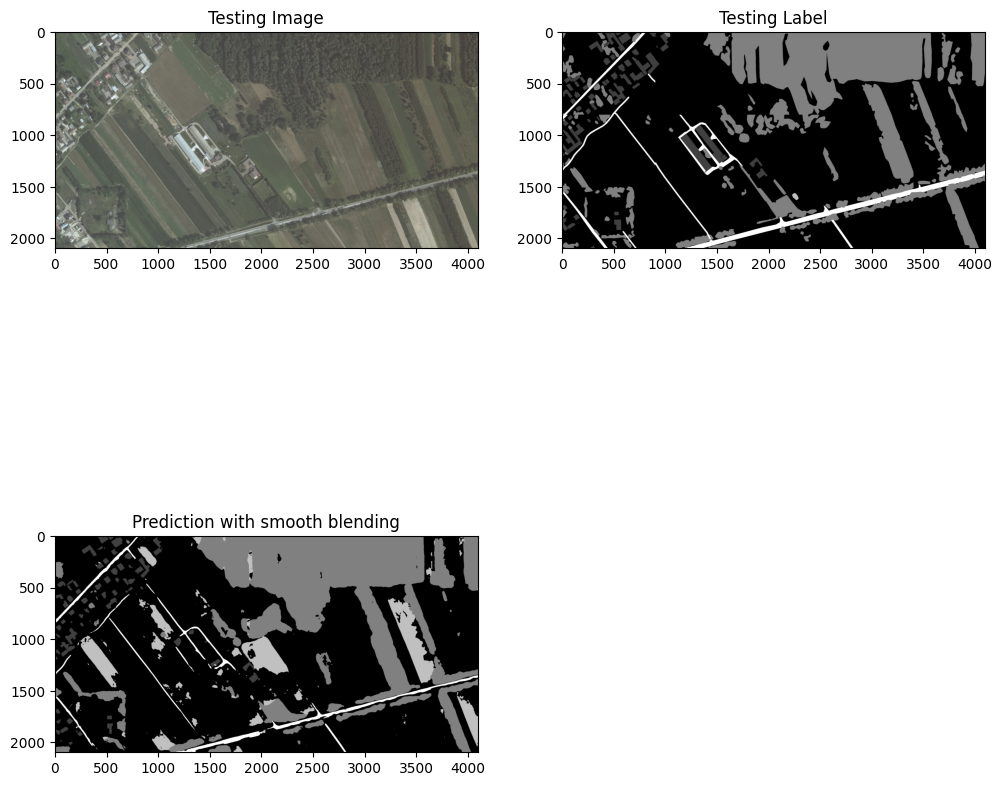

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from keras.models import load_model
import time
# Set your backbone, preprocess_input, patch_size, and n_classes here
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
# size of patches
patch_size = 256

# Number of classes 
n_classes = 5

# Specify the directory containing the images
image_directory = "../LargeImagesBatched/batch_1/images"
mask_directory = "../LargeImagesBatched/batch_1/masks"

# Define the result directory
result_directory_mask = f'segmentation_results/{BACKBONE}/mask/'
result_directory_segmented = f'segmentation_results/{BACKBONE}/segmented/'
os.makedirs(result_directory_mask, exist_ok=True)
os.makedirs(result_directory_segmented, exist_ok=True)

# List all image files in the directory
image_files = [file for file in os.listdir(image_directory) if file.endswith(".tif")]

# Load the model
model = load_model(f'../FurtherTraining/CheckPoints/{BACKBONE}/weights-improvement_resnet34.hdf5', compile=False)

# Loop through each image file in the directory
for image_file in image_files:
    # Load the image
    img = cv2.imread(os.path.join(image_directory, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_img = preprocess_input(img)

    # Load the corresponding mask
    mask_file = os.path.splitext(image_file)[0] + ".tif"
    original_mask = cv2.imread(os.path.join(mask_directory, mask_file))
    # original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)
    original_mask = original_mask[:, :, 0]

    # Predict using smooth blending
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2,
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )
    final_prediction = np.argmax(predictions_smooth, axis=2).astype(np.uint8)
    print(final_prediction.shape)  # Check shape
    print(original_mask.shape)      # Check shape
    # Save the final prediction and original mask
    result_image_file = f'{result_directory_segmented}{os.path.splitext(image_file)[0]}_segmented_{BACKBONE}.jpg'
    result_mask_file = f'{result_directory_mask}{os.path.splitext(image_file)[0]}_mask_{BACKBONE}.jpg'
    print(result_image_file)
    print(result_mask_file)
    # cv2.imwrite(result_image_file, final_prediction)
    # cv2.imwrite(result_mask_file, original_mask)
    plt.imsave(result_image_file, final_prediction)
    plt.imsave(result_mask_file, original_mask)
    # Display the images if needed
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(img)
    plt.subplot(222)
    plt.title('Testing Label')
    plt.imshow(original_mask, cmap = 'gray')
    plt.subplot(223)
    plt.title('Prediction with smooth blending')
    plt.imshow(final_prediction, cmap= 'gray')
    plt.show()
